In [1]:
import praw
import creds

reddit = praw.Reddit(
    client_id=creds.CLIENT_ID,
    client_secret=creds.CLIENT_SECRET,
    user_agent=creds.USER_AGENT
)
 

In [2]:
import pandas as pd
from datetime import datetime, timedelta

#subreddits = ["moving", "florida", "realestate", "homeowners", "personalfinance"]
subreddits = ["florida"]

def fetch_posts(subreddit, time_filter="year", limit=500):
    posts = []
    try:
        for submission in reddit.subreddit(subreddit).top(time_filter=time_filter, limit=limit): #change from search to top
            posts.append({
                "subreddit": subreddit,
                "title": submission.title,
                "selftext": submission.selftext,
                "created_utc": datetime.utcfromtimestamp(submission.created_utc),
                "upvotes": submission.score,
                "num_comments": submission.num_comments,
                "url": submission.url
            })            
            print(f"Fetched {len(posts)} posts from r/{subreddit}")
    except Exception as e:
        print(f"Error fetching posts from r/{subreddit}: {e}")
    return posts

# Collect data from multiple subreddits
all_posts = []
for sub in subreddits:
    all_posts.extend(fetch_posts(sub, time_filter="all", limit=500))

df = pd.DataFrame(all_posts)
df.to_csv("test.csv", index=False)

Fetched 1 posts from r/florida
Fetched 2 posts from r/florida
Fetched 3 posts from r/florida
Fetched 4 posts from r/florida
Fetched 5 posts from r/florida
Fetched 6 posts from r/florida
Fetched 7 posts from r/florida
Fetched 8 posts from r/florida
Fetched 9 posts from r/florida
Fetched 10 posts from r/florida
Fetched 11 posts from r/florida
Fetched 12 posts from r/florida
Fetched 13 posts from r/florida
Fetched 14 posts from r/florida
Fetched 15 posts from r/florida
Fetched 16 posts from r/florida
Fetched 17 posts from r/florida
Fetched 18 posts from r/florida
Fetched 19 posts from r/florida
Fetched 20 posts from r/florida
Fetched 21 posts from r/florida
Fetched 22 posts from r/florida
Fetched 23 posts from r/florida
Fetched 24 posts from r/florida
Fetched 25 posts from r/florida
Fetched 26 posts from r/florida
Fetched 27 posts from r/florida
Fetched 28 posts from r/florida
Fetched 29 posts from r/florida
Fetched 30 posts from r/florida
Fetched 31 posts from r/florida
Fetched 32 posts 

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download("punkt_tab")

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text.lower())  # Remove special characters
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

df["clean_text"] = df["title"] + " " + df["selftext"]
df["clean_text"] = df["clean_text"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


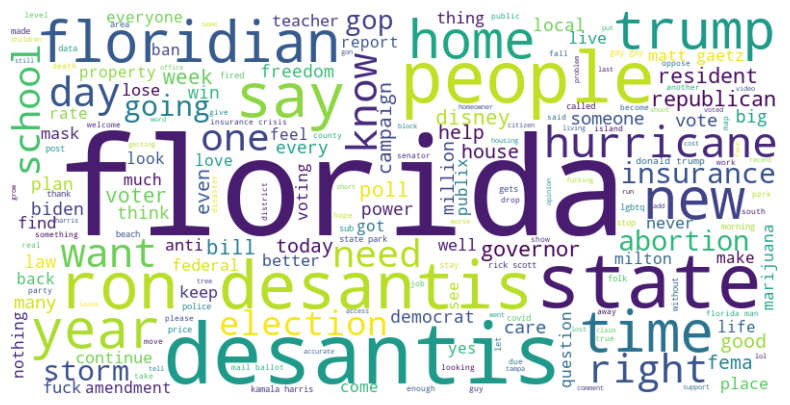

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df["clean_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}: ", [terms[i] for i in topic.argsort()[-10:]])


Topic 1:  ['anti', 'man', 'abortion', 'plan', 'golf', 'home', 'desantis', 'parks', 'state', 'florida']
Topic 2:  ['like', 'years', 'want', 'say', 'time', 'ron', 'state', 'people', 'desantis', 'florida']
Topic 3:  ['harris', 'gay', 'new', 'poll', 'hurricane', 'insurance', 'ron', 'trump', 'desantis', 'florida']
Topic 4:  ['going', 'like', 'good', 'know', 'vote', 'day', 'ballot', 'election', 'mail', 'florida']
Topic 5:  ['pool', 'water', 'people', 'biden', 'morning', '000', 'fema', 'power', 'state', 'florida']


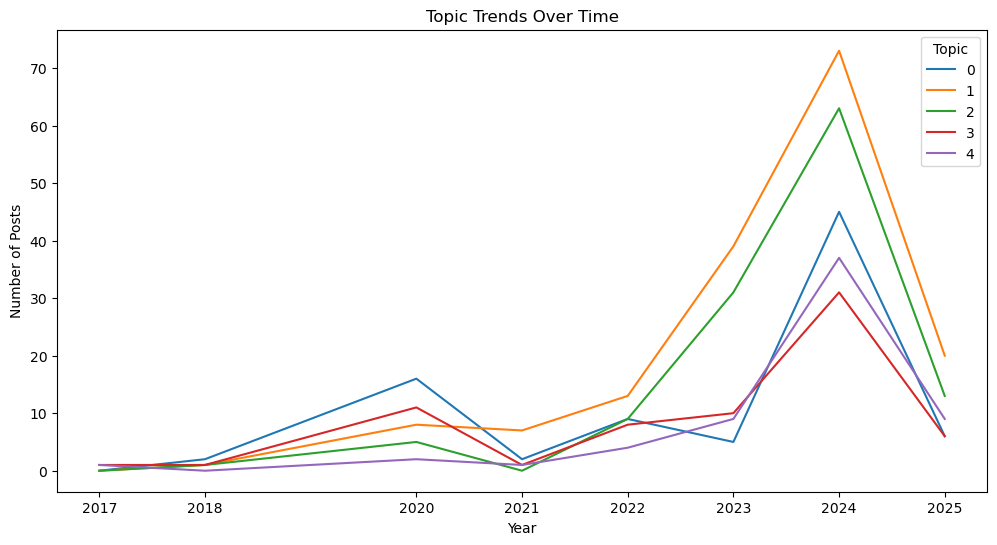

topic   0   1   2   3   4
year                     
2017    0   0   0   1   1
2018    2   1   1   1   0
2020   16   8   5  11   2
2021    2   7   0   1   1
2022    9  13   9   8   4
2023    5  39  31  10   9
2024   45  73  63  31  37
2025    6  20  13   6   9


In [6]:
# Assign Topics to Posts
def get_topic(text):
    bow = vectorizer.transform([text]) #transform the text to a bag of words.
    topic_distribution = lda.transform(bow) #get the topic distribution.
    return topic_distribution.argmax() #return the highest probability topic.

df["topic"] = df["clean_text"].apply(get_topic)

# Add Year Column
df["year"] = df["created_utc"].dt.year

# Group by Year and Topic
topic_trends = df.groupby(["year", "topic"]).size().unstack(fill_value=0)

# Visualize Topic Trends
topic_trends.plot(kind="line", figsize=(12, 6))
plt.title("Topic Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.xticks(topic_trends.index) #set the x axis to only show years where data exists.
plt.legend(title="Topic")
plt.show()

#display the topic trends data.
print(topic_trends)

In [7]:
# import seaborn as sns

# df["year"] = df["created_utc"].dt.year
# df_yearly = df.groupby("year").size().reset_index(name="post_count")

# plt.figure(figsize=(10,5))
# sns.lineplot(data=df_yearly, x="year", y="post_count", marker="o")
# plt.title("Number of Posts Discussing Moving to Florida (Yearly)")
# plt.xlabel("Year")
# plt.ylabel("Post Count")
# plt.show()


In [8]:
# from textblob import TextBlob

# def get_sentiment(text):

#     return TextBlob(text).sentiment.polarity

# df["sentiment"] = df["clean_text"].apply(get_sentiment)

# plt.figure(figsize=(8,5))
# sns.histplot(df["sentiment"], bins=20, kde=True)
# plt.title("Sentiment Distribution of Florida Migration Posts")
# plt.xlabel("Sentiment Score")
# plt.ylabel("Frequency")
# plt.show()


In [9]:
# from prophet import Prophet

# # Aggregate post count by month
# df["month"] = df["created_utc"].dt.to_period("M").astype(str)
# df_monthly = df.groupby("month").size().reset_index(name="post_count")

# # Rename columns for Prophet
# df_monthly.rename(columns={"month": "ds", "post_count": "y"}, inplace=True)
# df_monthly["ds"] = pd.to_datetime(df_monthly["ds"])  # Convert to datetime format

# # Display first few rows
# df_monthly.head()

In [10]:
# # Initialize and fit the Prophet model
# model = Prophet()
# model.fit(df_monthly)

# # Create a dataframe with future dates (next 12 months)
# future = model.make_future_dataframe(periods=12, freq="M")

# # Generate forecast
# forecast = model.predict(future)

# # Show forecasted data
# forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

In [11]:
# import matplotlib.pyplot as plt

# # Plot the forecast
# fig = model.plot(forecast)
# plt.title("Forecast of Florida Migration Discussions on Reddit")
# plt.xlabel("Year")
# plt.ylabel("Number of Posts")
# plt.show()

In [12]:
# fig2 = model.plot_components(forecast)
# plt.show()